## Zadanie 8

In [102]:
import numpy as np
import hashlib
import struct
import random
import math
import matplotlib.pyplot as plt

In [318]:
def min_count_hash(x):
    [number] = struct.unpack("<I", hashlib.md5(x).digest()[:4])
    return number / float(0xFFFFFFFF)

def bitstring_hash(hash_f, x):
    string = hash_f(x).hexdigest()
    return bin(int(string, 16))[-32:]

def p(x):
    return x.index('1') + 1 if '1' in x else len(x) + 1

def alpha(m):
    if m == 16:
        return 0.673
    if m == 32:
        return 0.697
    if m == 64:
        return 0.709
    return 0.7213 / (1 + 1.079 / m)

In [315]:
class HyperLogLog:
    def __init__(self, b, hash_f):
        self.b = b
        self.hash_f = hash_f
        self.m = 2 ** b
        self.registers = np.zeros(self.m)

    def push(self, v):
        x = bitstring_hash(self.hash_f, v)
        j = int(x[:self.b], 2)
        w = x[self.b:]
        self.registers[j] = max(self.registers[j], p(w))
    
    def count(self):
        m = self.m
        registers = self.registers

        E = alpha(m) * (m ** 2) * ((np.sum(np.power(2, -registers))) ** (-1))

        if E <= (5 / 2 * m):
            V = sum(registers == 0)
            if V != 0:
                E = -m * math.log(V / m)

        if E > (2 ** 32) / 30:
            H_c = 2 ** 32
            E = - H_c * np.log((H_c - E) / H_c)

        return E

In [311]:
class MinCount:
    def __init__(self, k, hash_f):
        self.k = k
        self.hash_f = hash_f
        self.M = [1] * k

    def push(self, elem):
        h = self.hash_f(elem)
        if h < self.M[-1] and h not in self.M:
            self.M[-1] = h
            self.M.sort()

    def count(self):
        if self.M[-1] == 1:
            return sum([1 for x in self.M if x != 1])

        return (self.k - 1) / self.M[-1]

### Badania

In [327]:
def hyper_log_log_experiment(b, m):
    res = []
    for n in range(1, 10 ** 4 + 1):
        hyperlog = HyperLogLog(b, hashlib.sha256)

        for e in range(n ** 2, n ** 2 + n):
            p = struct.pack("i", e)
            for _ in range(m(e)):
                hyperlog.push(p)

        count = hyperlog.count()
        res.append((n, count / float(n)))
    
    return res

def min_count_experiment(k, m):
    res = []
    for n in range(1, 10 ** 4 + 1):
        min_count = MinCount(k, min_count_hash)

        for e in range(n ** 2, n ** 2 + n):
            p = struct.pack("i", e)
            for _ in range(m(e)):
                min_count.push(p)

        res.append((n, min_count.count() / float(n)))
    
    return res

### a)

In [317]:
def m1(e):
    return 1

def m2(e):
    return 2

print(np.average(hyper_log_log_experiment(4, m1)))
print(np.average(hyper_log_log_experiment(4, m2)))

2500.7498301941514
2500.7498301941514


### b)

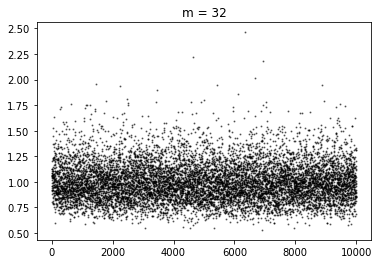

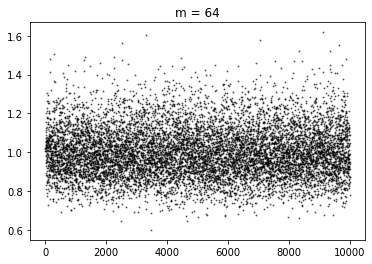

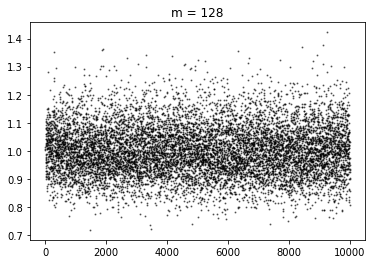

KeyboardInterrupt: 

In [329]:
for b in [5, 6, 7, 8, 9, 10]:
    r = hyper_log_log_experiment(b, m1)
    x, y = zip(*r)
    plt.title("m = " + str(2 ** b))
    plt.scatter(x, y, alpha=0.5,s =1, c="k")
    plt.show()

### Porównanie MinCount i HyperLogLog

In [330]:
b = 10
k = 400

r1 = hyper_log_log_experiment(b, m1)
r2 = min_count_experiment(k, m1)

In [336]:
r3 = min_count_experiment(1024, m1)

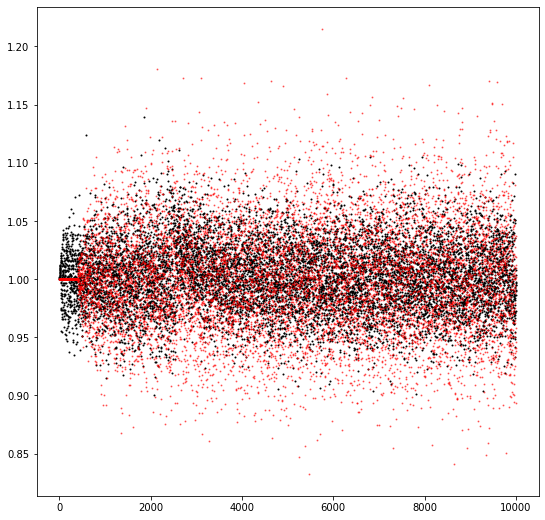

In [340]:
plt.figure(1, figsize=(9, 9))
plt.scatter(*zip(*r1), alpha=1,s =1, c="k")
plt.scatter(*zip(*r2), alpha=0.5, c="r", s=1)
plt.show()